# Final Project Example

## Retrieve/Scrape the Data

In [13]:
import requests
import json
import pandas as pd

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAKIqKQEAAAAArvCY9UR1YF2ItjDVfvxRj%2BacYLI%3Dobk23ATK7g32XQ7CQiotckLl5EkTIfqJQGvIWWSNOUNRxTN0Dc'
headers = {'Authorization':('Bearer '+ bearer_token)}

# In this example, only those tweets with photos/images are stored

n = 10000                         # The total number of tweets we want
max_results = 100                 # The number of tweets to pull per request; must be between 10 and 100
total_retrieved = 0               # To keep track of when to stop
next_token = ""                   # Must be empty on first iteration
search_term = "covid%20gofundme"  # To form an advanced query, see here: https://twitter.com/search-advanced?lang=en
since_id = "1372000000000000000"  # The id of the oldest tweet you want to retrieve

# Create the empty DataFrame with the columns you want
df = pd.DataFrame(columns=['id', 'created_at', 'retweets', 'likes', 'replies', 'quotes', 'user_followers', 'user_following', 'user_listed', 'user_tweets', 'has_media', 'url', 'text'])
df.set_index('id', inplace=True)

# stop when we have n results
while total_retrieved < n:

  # the first time through the loop, we do not need the next_token parameter
  if next_token == "":
    url = f'https://api.twitter.com/2/tweets/search/recent?query={search_term}&max_results={max_results}&since_id={since_id}'
  else:
    url = f'https://api.twitter.com/2/tweets/search/recent?query={search_term}&max_results={max_results}&since_id={since_id}&next_token={next_token}'

  # These are the extra parameters we will add to the querystring; we won't store them all though; just want you to see what's possible
  url += f'&user.fields=id,public_metrics'
  url += f'&tweet.fields=attachments,public_metrics,text,created_at,author_id'
  url += f'&expansions=attachments.media_keys,author_id'
  url += f'&media.fields=media_key,type,url'

  # make the request to the Twitter API Recent Search endpoint
  response = requests.request("GET", url, headers=headers)
  try:  # Just in case we get an error
    json_data = json.loads(response.text)
  except:
    print(response.text)
  
  # Error checking; print the results if valid data is not retrieved
  if not 'data' in json_data:
    json_clean = json.dumps(json_data, indent=2, sort_keys=True)
    print(json_clean)


  for tweet in json_data['data']:
    media_key = ""  # Reset to empty each time through the loop so that we can use it for a condition later

    # Store the data into variables
    tweet_id = tweet['id']
    try:
      author_id = tweet['author_id']
    except:
      print(tweet)
    created_at = tweet['created_at']
    retweet_count = tweet['public_metrics']['retweet_count']
    like_count = tweet['public_metrics']['like_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    user_followers = ""
    user_following = ""
    user_listed = ""
    user_tweets = ""
    has_media = False
    image_url = ""
    text = tweet['text']

    # Find out if there is media
    if 'attachments' in tweet:
      if 'media_keys' in tweet['attachments']:
        media_key = tweet['attachments']['media_keys'][0]

    # If there is a media key in this tweet, iterate through tweet['includes']['media'] until we find it
    if media_key != "":
      for media in json_data['includes']['media']:
        if media['media_key'] == media_key: # Only if the media_key matches the one we stored
          has_media = True
          if media['type'] == 'photo':      # Only if it is a photo; ignore videos
            image_url = media['url']        # Store the url in a variable
            break
    
    
    # Iterate through all authors until we find the author of this tweet; then store their metrics
    for author in json_data['includes']['users']:
      if author['id'] == author_id:
        user_followers = author['public_metrics']['followers_count']
        user_following = author['public_metrics']['following_count']
        user_listed = author['public_metrics']['listed_count']
        user_tweets = author['public_metrics']['tweet_count']
        break
                
    # Only add the record in the DataFrame if a photo is found
    df.loc[tweet_id] = [created_at, retweet_count, like_count, reply_count, quote_count, user_followers, user_following, user_listed, user_tweets, has_media, image_url, text]


  # keep track of where to start next time, but quit if there are no more results
  try:
    total_retrieved += json_data['meta']['result_count']
    next_token = json_data['meta']['next_token']
  except:
    break  

df.to_csv('twitter.csv')
df.head()

,created_at,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,has_media,url,text
id,,,,,,,,,,,,
1374435243881467919,2021-03-23T18:57:52.000Z,818,0,0,0,983,1272,19,163569,False,,RT @OrlvndoA: Soledad Bravo necesita apoyo par...
1374435204496957447,2021-03-23T18:57:43.000Z,60,0,0,0,12,25,0,2092,False,,RT @cmrondon: Campaña de Enrique Bravo : SOLED...
1374435181365395461,2021-03-23T18:57:37.000Z,38,0,0,0,64,216,1,2380,False,,RT @DolarToday: ATENCIÓN ATENCIÓN *SOLEDAD BRA...
1374435179477962759,2021-03-23T18:57:37.000Z,346,0,0,0,351,501,13,17258,False,,RT @AliasMalula: La gran Soledad Bravo cayó ví...
1374435177846300673,2021-03-23T18:57:36.000Z,4,0,0,0,163,384,0,3128,True,https://pbs.twimg.com/media/ExL4HcXUUAspecd.jpg,"RT @danhrr: Es para mi tía, favor difundir 🙏🏻\..."


  
    
    
    
    
## Exploratory Data Analysis (i.e. Data Understanding Phase)
### Begin with univariate analyses

In [82]:
import pandas as pd
df = pd.read_csv('twitter.csv')
df.shape

(10048, 13)

In [83]:
# Convert these numbers to categories
df['id'] = df['id'].astype('object')

# Parse out the date into potentially useful features
df['created_at'] = pd.to_datetime(df['created_at'])
df['Weekday'] = df['created_at'].dt.day_name()
df['DayOfWeek'] = df['created_at'].dt.dayofweek
df['Hour'] = df['created_at'].dt.hour
df.drop(columns=['created_at'], inplace=True)

df.describe()

,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,DayOfWeek,Hour
count,10048.000000,10048.000000,10048.000000,10048.000000,1.004800e+04,10048.000000,10048.000000,1.004800e+04,10048.000000,10048.000000
mean,261.212082,0.550259,0.032743,0.018412,1.118056e+04,1620.492138,48.927946,5.466378e+04,2.547671,13.076334
std,587.716735,8.509941,0.464766,0.263502,1.813830e+05,10421.514564,666.369005,2.562607e+05,2.271402,6.677803
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000,0.000000
25%,14.000000,0.000000,0.000000,0.000000,1.130000e+02,246.000000,0.000000,3.477000e+03,1.000000,7.000000
50%,85.000000,0.000000,0.000000,0.000000,3.580000e+02,592.000000,2.000000,1.524600e+04,1.000000,16.000000
75%,347.000000,0.000000,0.000000,0.000000,1.059000e+03,1388.000000,8.000000,4.851325e+04,5.000000,18.000000
max,46574.000000,380.000000,20.000000,15.000000,7.114117e+06,372818.000000,36972.000000,7.544377e+06,6.000000,23.000000


In [84]:
df.skew()

id                -0.494357
retweets          49.296705
likes             30.030644
replies           28.232972
quotes            29.559215
user_followers    26.171626
user_following    30.156395
user_listed       32.490984
user_tweets       22.823147
has_media         10.194807
DayOfWeek          0.469426
Hour              -0.718037
dtype: float64


  
### Continue with bivariate analyses

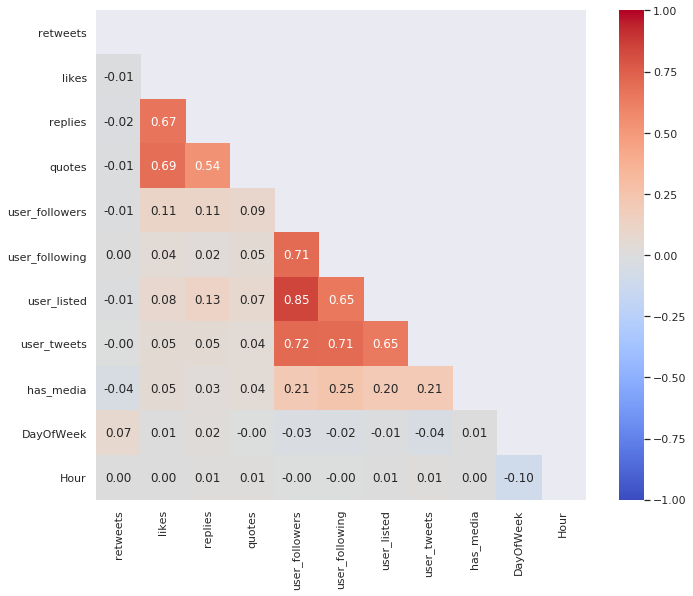

In [89]:
# Create a heatmap over a correlation table

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.2f', 
            vmin=-1, vmax=1, center=0, cmap= 'coolwarm', 
            mask=matrix, square=True);

In [91]:
df.dtypes

id                object
retweets           int64
likes              int64
replies            int64
quotes             int64
user_followers     int64
user_following     int64
user_listed        int64
user_tweets        int64
has_media           bool
url               object
text              object
Weekday           object
DayOfWeek          int64
Hour               int64
dtype: object

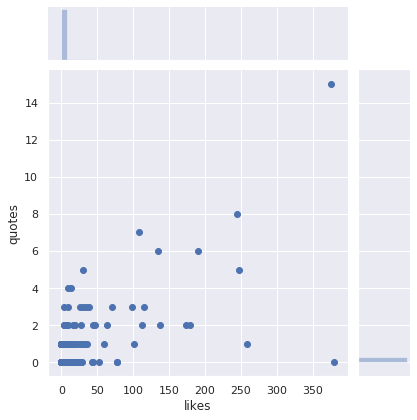

In [92]:
sns.set(color_codes=True)
sns.jointplot(x='likes', y='quotes', data=df);

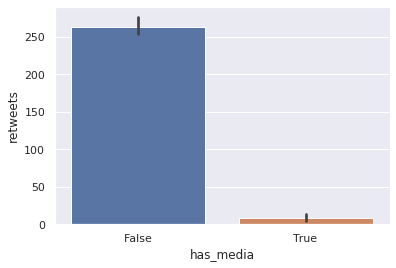

In [93]:
sns.barplot(data=df, x="has_media", y="retweets");

# Text Processing

In [94]:
!pip install --upgrade pip
!pip install pyLDAvis
!pip install bokeh
!pip install gensim
!pip install spacy
!pip install logging
!pip install warnings
!pip install matplotlib
!pip install nltk
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install -U seaborn
!pip install translators --upgrade

     |████████████████████████████████| 1.5 MB 29.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 1.7 MB 16.8 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3 MB 98.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 87.6 MB/s eta 0:00:01
     |████████████████████████████████| 24.2 MB 103.0 MB/s eta 0:00:01     |████████████████████████████▏   | 21.4 MB 103.0 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 99.7 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.0-py2.py3-none-any.whl size=136817 sha256=4b2dfe4c011c2c9e56044d329c59de4d263f3a88e6e9c235703208fdb74d27c0
  Stored in directory: /root/.cache/pip/wh

In [95]:
def translate(text):
  import translators as ts
  translated = ""

  # input languages
  try:
    print(ts.deepl(wyw_text, from_language='auto', to_language='en'))
  except:
    pass

  # output language_map
  try:
    print(ts._deepl.language_map)
  except:
    pass

  # professional field
  try:
    translated = ts.alibaba(wyw_text, professional_field='general') # ("general","message","offer")
  except:
    pass

  if translated == "":
    try:
      translated = ts.baidu(wyw_text, professional_field='common') # ('common','medicine','electronics','mechanics')
    except:
      pass

  # property
  try:
    rs = [ts.tencent(x) for x in [wyw_text, chs_text]]
    print(ts._tencent.query_count)
    print(dir(ts._tencent))
  except:
    pass

  # requests
  if translated == "":
    try:
      translated = ts.youdao(wyw_text, sleep_seconds=5, proxies={})
    except:
      pass

  # host service
  if translated == "":
    try:
      translated = ts.google(wyw_text, if_use_cn_host=True)
      translated = ts.bing(wyw_text, if_use_cn_host=False)
    except:
      pass

  # detail result
  print(ts.sogou(wyw_text, is_detail_result=True))
        
  # translate html
  # print(ts.translate_html(html_text, translator=ts.google, to_language='en', translator_params={}))
        
  # help
  # help(ts.deepl)
  return translated

print(translate("La gran Soledad Bravo cayó ví"))

None


Using United States server backend.


NameError: name 'wyw_text' is not defined

# Modeling

In [52]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regression algorithm
from sklearn.ensemble import GradientBoostingRegressor # Import XGBoost algorithm 
from sklearn.model_selection import train_test_split # Import train_test_split function
# for a completelist of available algorithms: https://scikit-learn.org/stable/supervised_learning.html
# Which one should I use?: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [53]:
# Create dummy codes for all features and not the label

df.drop(columns=['id', 'text'], inplace=True)

for col in df.columns:
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns=[col], prefix=col)

df.head()

,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,has_media,id_1372922770024230912,...,text_🎈Shoutout to Cess M. for donating $100.\n\nYou’ve earned a Swagmate Reward: custom t-shirt &amp; hoodie https://t.co/H2b6TN2vY2\n\n*We’ll start shipping gifts in Q3 2021. \n\nThank you. \n\n#ad #giveaway,text_🎈Shoutout to Cess M. for donating $100.\n\nYou’ve earned a Swagmate Reward: custom t-shirt &amp; hoodie https://t.co/TxBC6iYCRv\n\n*We’ll start shipping gifts in Q3 2021. \n\nThank you.,text_🎈Shoutout to Cess M. for donating $100.\n\nYou’ve earned a Swagmate Reward: custom t-shirt &amp; hoodie https://t.co/z2ZgDHrben\n\n*We’ll start shipping gifts in Q3 2021. \n\nThank you. #ad,"text_👉Millions of people have still recieved no financial support at all - could you survive of no income, no benefits for 12 months? 👈\n\nPlease retweet ♻️ and Like ❤ and support those who have been #ExcludedUk #FirstInLastOut \n\nhttps://t.co/kxD1fGX0fy",text_💰💰It cost at least $350 an hour to keep the ranch open. During #COVID19 we have been struggling to care for our horses 🐎 and need your support. Donate today on #GoFundMe \nhttps://t.co/EYlcAtn8pH\n#InThisTogether https://t.co/f90nY9cupq,text_💰💰It cost at least $350 an hour to keep the ranch open. During #COVID19 we have been struggling to care for our horses 🐎 and need your support. Donate today on #GoFundMe \nhttps://t.co/EYlcAtn8pH\n#InThisTogether https://t.co/z9Laa5Stro,text_📢📢📢📢📢📢📢📢📢📢📢\n\n#SERVICIOPÚBLICO\n#AYUDAADIFUNDIR\n\nhttps://t.co/u0F8p9hPa0,"text_🔴 ¡Ayudemos! 🔴 La psiquiatra Lourdes Torrealba, la concejal Liris Loreto y Soledad Bravo piden colaboración para superar crisis de COVID-19 en GoFundMe\n\n👇🏻",text_🙏🏻🙏🏻🙏🏻\n\nAyuda a Pedro a superar el COVID-19 https://t.co/WE0pkupSvC,text_🚨🚨🚨\n\nPlease donate to Nzingha so she can afford to register for classes and complete her undergrad! Due to COVID and financial constraints she has to pay off a huge balance in her school fees. This is extremely urg*nt her last donation was 5 days ago!\n\nhttps://t.co/EzJvOxO7dp https://t.co/HoX2WYiOaI
0,818,0,0,0,983,1272,19,163569,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60,0,0,0,12,25,0,2092,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,0,0,0,64,216,1,2380,0,0,...,0,0,0,0,0,0,0,0,0,0
3,346,0,0,0,351,501,13,17258,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,163,384,0,3128,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Split dataset in features and target variable

y = df.charges # Label
X = df.drop(columns=['charges']) # Features
X = X.select_dtypes(np.number)
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X_train.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
744,50,26.41,0,0,1,1,0,0,1,0,0
363,21,26.40,1,1,0,1,0,0,0,0,1
10,25,26.22,0,0,1,1,0,1,0,0,0
970,50,28.16,3,1,0,1,0,0,0,1,0
634,51,39.70,1,0,1,1,0,0,0,0,1


In [18]:
# Create Decision Tree regressor object
clf = DecisionTreeRegressor()

# Train Decision Tree regressor
clf = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clf.predict(X_test)

In [19]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

,Actual,Predicted
559,1646.42970,1263.24900
1087,11353.22760,11945.13270
1020,8798.59300,8457.81800
460,10381.47870,10702.64240
802,2103.08000,1964.78000
298,38746.35510,39983.42595
481,9304.70190,9048.02730
616,11658.11505,11658.37915
763,3070.80870,3558.62025
750,19539.24300,20149.32290


In [20]:
# Import scikit-learn metrics module. See complete list of Classification metrics here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn import metrics
    
print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

R squared:	0.7192346766990366
MAE:		2964.1516434800997
RMSE:		6307.862354958355


In [21]:
# Create XGBoost regressor object
clr = GradientBoostingRegressor()

# Train Decision Tree regression
clr = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clr.predict(X_test)

In [22]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

,Actual,Predicted
559,1646.42970,1263.24900
1087,11353.22760,11842.62375
1020,8798.59300,8457.81800
460,10381.47870,10702.64240
802,2103.08000,1964.78000
298,38746.35510,55135.40209
481,9304.70190,9048.02730
616,11658.11505,11658.37915
763,3070.80870,3558.62025
750,19539.24300,20149.32290


In [23]:
from sklearn import metrics
    
print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

R squared:	0.7184834368316932
MAE:		2987.658830445274
RMSE:		6316.295647265444


In [24]:
import pickle

# Save the model with the highest fit metric
pickle.dump(clr, open('stored_model.sav', 'wb'))  # OPTION 1: pickle

['stored_model.pkl']

In [25]:
# ...some time later

import pickle
import numpy as np

# OPTION 1: Using pickle
# load the model from 'stored_model.sav'
loaded_model = pickle.load(open('stored_model.sav', 'rb'))
print(type(loaded_model))

# for a single prediction, enter a row of data and reshape into numpy array
case = [0.543478, 0.245359, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
print(f'Single prediction {case}: {loaded_model.predict(np.array(case).reshape(1, -1))[0]}\n')

# for a batch prediction, enter a Pandas DataFrame or a Numpy array of arrays
predictions = loaded_model.predict(X_test) 
batch_results = pd.DataFrame({'Actual':y_test, 'Predicted':predictions, 'Diff':(predictions - y_test)})
print(f'MAE:\t{batch_results.Diff.abs().mean()}\n')
batch_results.head(5)

<class 'sklearn.tree._classes.DecisionTreeRegressor'>
Single prediction [0.543478, 0.245359, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]: 16420.49455

MAE:	2987.6588304452744



,Actual,Predicted,Diff
559,1646.4297,1263.24900,-383.18070
1087,11353.2276,11842.62375,489.39615
1020,8798.5930,8457.81800,-340.77500
460,10381.4787,10702.64240,321.16370
802,2103.0800,1964.78000,-138.30000
